# Brain MRI Segmentation

This notebook contains a simplistic code for barin MRI segmentation task. 
[The dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) that is used here contains only 110 patients and is obtained from The Cancer Genome Atlas (TCGA).
Also, some parts of this code are building on top of [this notebook](https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch).

In [1]:
import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader

from datasets.brain_dataset import BrainSegmentationDataset
from datasets.transforms import ToTensor, ToImage, get_transforms
from models.unet import UNet
from metrics.dice_loss import DiceLoss, dice_score
from train import train_supervised, train_eval_supervised
from evaluate import generate_outputs
from utils.params import Params
from utils.logger import set_logger
from utils.visualizer import plot_samples

%matplotlib inline
%load_ext tensorboard

In [2]:
dataset_dir = "/pasteur/u/mottaghi/lgg-mri-segmentation/processed"
base_params_path = "experiments/base_params.json"
model_dir = "experiments/supervised_run5"
restore = True

os.makedirs(model_dir, exist_ok=True)
params_path = os.path.join(model_dir, "params.json")
if restore and os.path.exists(params_path):
    params = Params(params_path)
else:
    params = Params(base_params_path)
    params.save(params_path)
params.model_dir = model_dir
params.restore = restore
params.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

set_logger(model_dir)

In [3]:
train_transforms = get_transforms(params)
totensor = ToTensor()
toimage = ToImage()

### Data

In [4]:
train_dataset = BrainSegmentationDataset(dataset_dir, subset="labeled", transform=train_transforms, params=params)
val_dataset = BrainSegmentationDataset(dataset_dir, subset="validation", transform=totensor, params=params)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, drop_last=False)

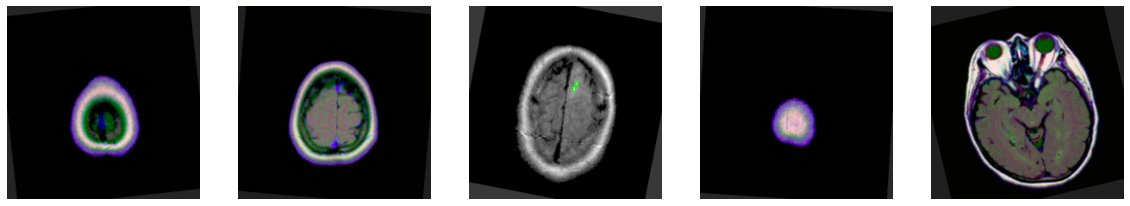

In [6]:
rand_idx = np.random.choice(len(train_dataset), 5)
samples = [toimage(train_dataset[idx]) for idx in rand_idx]
plot_samples(samples)

### Training

In [7]:
model = UNet(in_channels=3, out_channels=1)
model.to(params.device)
optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
loss_fn = DiceLoss()
metrics = {'dice score': dice_score}

In [8]:
# logs_dir = os.path.join(params.model_dir, "logs")
# %tensorboard --logdir {logs_dir} --host 0.0.0.0 --port 8822

In [9]:
train_eval_supervised(model, optimizer, loss_fn, train_loader, val_loader, metrics, params)

Restoring parameters from experiments/supervised_run5/checkpoints/best.pth.tar
Epoch 174/200
100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.290]
- Train metrics: dice score: 0.903 ; loss: 0.298
- Eval metrics : dice score: 0.625 ; loss: 0.577
Epoch 175/200
100%|██████████| 10/10 [00:02<00:00,  3.93it/s, loss=0.265]
- Train metrics: dice score: 0.930 ; loss: 0.310
- Eval metrics : dice score: 0.624 ; loss: 0.564
Epoch 176/200
100%|██████████| 10/10 [00:02<00:00,  3.59it/s, loss=0.294]
- Train metrics: dice score: 0.943 ; loss: 0.212
- Eval metrics : dice score: 0.653 ; loss: 0.578
Epoch 177/200
100%|██████████| 10/10 [00:02<00:00,  3.80it/s, loss=0.303]
- Train metrics: dice score: 0.967 ; loss: 0.126
- Eval metrics : dice score: 0.691 ; loss: 0.597
Epoch 178/200
100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=0.292]
- Train metrics: dice score: 0.928 ; loss: 0.332
- Eval metrics : dice score: 0.703 ; loss: 0.578
Epoch 179/200
100%|██████████| 10/10 [00:02<00:00,  3.92it/s,

### Evaluation

In [10]:
output_list = generate_outputs(model, val_loader, params, save=True)

/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_155.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_207.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_208.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_209.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_260.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run5/outputs/val_295.png is a low contrast image
  imsave

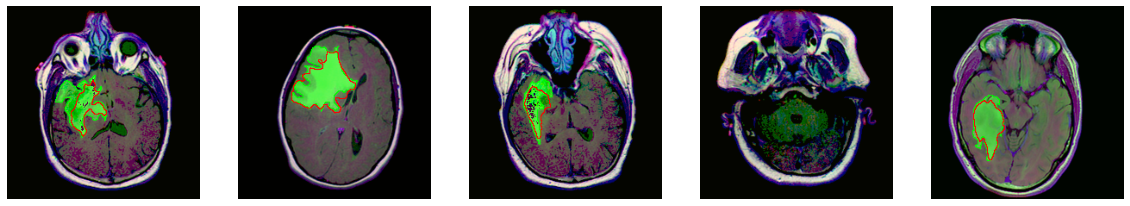

In [15]:
rand_idx = np.random.choice(len(output_list), 5)
samples = [output_list[idx] for idx in rand_idx]
plot_samples(samples)